### 问题3： 教练们很想知道是否有一些指标可以帮助确定何时 比赛流程即将从有利于一名球员转变为另一名球员。 o 使用至少一场比赛提供的数据，开发一个模型来预测比赛中的这些波动。哪 些因素似乎最相关(如果有的话)? o 考虑到过去比赛中“动量”波动的差异，你如何建议一名球员进入一场与不同球员的新比赛?

#### 基于问题1提出的模型，我们可以知道对于每一个比分的预测是非常困难的，如果能够在总体上（即对于每一个game）能够判断是否获得胜利，同样是非常有价值的，因此，我们在问题1模型基础上对数据进行聚合，每一条样本表示的内容为一场game的信息，label即为对于当前game对局是否获得胜利。

剔除了得分异常的样本,删除了配速有缺失的样本

In [1]:
import pandas as pd
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
df = pd.read_csv('Wimbledon_featured_matches.csv')
df.loc[(df.p1_score=='AD'),'p1_score'] = 50
df.loc[(df.p2_score=='AD'),'p2_score'] = 50
df['p1_score'] = df['p1_score'].astype(int)
df['p2_score'] = df['p2_score'].astype(int)

df.dropna(subset=['speed_mph'],inplace=True)

C:\Windows\Temp\ipykernel_37284\4276802241.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
code = []

x1_ls,x2_ls,x3_ls,x4_ls,x5_ls,x6_ls,x7_ls,x8_ls,x9_ls,x10_ls,x11_ls,\
x12_ls,x13_ls,x14_ls,x15_ls,x16_ls=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
label_ls = []
for match_id in df.match_id.unique():
    t = df[df.match_id==match_id]
    for set_no in t.set_no.unique():
        t2 = t[t.set_no==set_no]
        for game_no in t2.game_no.unique():
            t3 = t2[t2.game_no==game_no]
            if t3['game_victor'].values[-1] == 1:
                label_ls.append(1)
            else:
                label_ls.append(0)
len(label_ls)

1108

In [3]:
code = []

x1_ls,x2_ls,x3_ls,x4_ls,x5_ls,x6_ls,x7_ls,x8_ls,x9_ls,x10_ls,x11_ls,\
x12_ls,x13_ls,x14_ls,x15_ls,x16_ls=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
label_ls = []
for match_id in df.match_id.unique():
    t = df[df.match_id==match_id]
    for set_no in t.set_no.unique():
        t2 = t[t.set_no==set_no]
        for game_no in t2.game_no.unique():
            t3 = t2[t2.game_no==game_no]
            if t3['game_victor'].values[-1] == 1:
                label_ls.append(1)
            else:
                label_ls.append(0)
for match_id,set_no,game_no,point_no in zip(df.match_id,df.set_no,df.game_no,df.point_no):
    code.append(f'{match_id}-{set_no}-{game_no}')
    match = df[df.match_id==match_id]
    set_ = match[match.set_no==set_no]
    game_ = set_[set_.game_no==game_no]
    point_ = game_[game_.point_no==point_no]
    x1 = point_['p1_games'].values[0]
    x2 = point_['p1_score'].values[0] - point_['p2_score'].values[0]
    x3 = 1 if point_['serve_no'].values[0] == 1 else 0
    x4 = 0 if x2<0 else 1
    x5 = point_['p1_sets'].values[0] - point_['p2_sets'].values[0]
    x6 = 1 if 1 in game_['p1_ace'].values else 0
    x7 = 1 if 1 in game_['p1_winner'].values else 0
    x8 = 1 if 1 in game_['p1_double_fault'].values else 0
    x9 = 1 if 1 in game_['p1_unf_err'].values else 0
    x10 = game_['p1_net_pt_won'].sum()/game_['p1_net_pt'].sum() if game_['p1_net_pt'].sum()!= 0 else 0
    x11 = set_['p1_break_pt_won'].sum()/set_['p1_break_pt'].sum() if game_['p1_break_pt'].sum()!= 0 else 0

    index = match.index.tolist().index(point_.index.tolist()[0])
    x12 = match.iloc[:index+1]['p1_distance_run'].sum()
    x13 = match.iloc[index-2:index+1]['p1_distance_run'].sum()
    x14 = point_['p1_distance_run'].values[0]
    x15 = point_['speed_mph'].values[0]
    x16 = x15*x3
    
    x1_ls.append(x1)
    x2_ls.append(x2)
    x3_ls.append(x3)
    x4_ls.append(x4)
    x5_ls.append(x5)
    x6_ls.append(x6)
    x7_ls.append(x7)
    x8_ls.append(x8)
    x9_ls.append(x9)
    x10_ls.append(x10)
    x11_ls.append(x11)
    x12_ls.append(x12)
    x13_ls.append(x13)
    x14_ls.append(x14)
    x15_ls.append(x15)
    x16_ls.append(x16)
    
dataset = pd.DataFrame({'x1':x1_ls,'x2':x2_ls,'x3':x3_ls,'x4':x4_ls,'x5':x5_ls,'x6':x6_ls,'x7':x7_ls,'x8':x8_ls,'x9':x9_ls,'x10':x10_ls,'x11':x11_ls,'x12':x12_ls,'x13':x13_ls,'x14':x14_ls,'x15':x15_ls,'x16':x16_ls})
dataset['game_code'] = code
dataset

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,game_code
0,0,0,0,1,0,1,1,0,1,1.0,0.0,6.000,0.000,6.000,95.0,0.0,2023-wimbledon-1301-1-1
1,0,-15,1,0,0,1,1,0,1,1.0,0.0,11.253,0.000,5.253,118.0,118.0,2023-wimbledon-1301-1-1
2,0,0,1,1,0,1,1,0,1,1.0,0.0,25.053,25.053,13.800,120.0,120.0,2023-wimbledon-1301-1-1
3,0,-15,1,0,0,1,1,0,1,1.0,0.0,76.161,70.161,51.108,130.0,130.0,2023-wimbledon-1301-1-1
4,0,0,1,1,0,1,1,0,1,1.0,0.0,76.810,65.557,0.649,112.0,112.0,2023-wimbledon-1301-1-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6219,5,-15,1,0,0,0,1,0,1,1.0,0.0,6270.624,49.542,38.620,123.0,123.0,2023-wimbledon-1701-5-10
6220,5,0,1,1,0,0,1,0,1,1.0,0.0,6288.157,62.925,17.533,114.0,114.0,2023-wimbledon-1701-5-10
6221,5,15,1,1,0,0,1,0,1,1.0,0.0,6299.039,67.035,10.882,124.0,124.0,2023-wimbledon-1701-5-10
6222,5,0,1,1,0,0,1,0,1,1.0,0.0,6306.932,36.308,7.893,130.0,130.0,2023-wimbledon-1701-5-10


#### 按照均值进行聚合

In [4]:
columns = dataset.columns[:-2]

dataset = dataset.groupby('game_code').mean()
dataset['label'] = label_ls
dataset

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,label
game_code,,,,,,,,,,,,,,,,,
2023-wimbledon-1301-1-1,0.0,0.000000,0.700000,0.800000,0.0,1.0,1.0,0.0,1.0,1.0,0.0,77.577200,39.222300,16.214500,112.400000,82.700000,1
2023-wimbledon-1301-1-2,1.0,-2.500000,0.875000,0.625000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,218.280125,39.420875,11.418375,119.625000,107.500000,0
2023-wimbledon-1301-1-3,1.0,17.000000,0.800000,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,290.857000,40.514400,14.444600,119.400000,98.800000,1
2023-wimbledon-1301-1-4,2.0,-21.250000,0.750000,0.250000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,354.968000,38.535250,12.114000,117.250000,90.500000,0
2023-wimbledon-1301-1-5,2.0,16.250000,0.625000,1.000000,0.0,0.0,1.0,0.0,1.0,1.0,0.0,421.888125,34.142000,11.525375,111.750000,72.500000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-wimbledon-1701-5-5,3.0,-22.000000,0.600000,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5899.982600,23.636800,10.675600,115.000000,73.600000,1
2023-wimbledon-1701-5-6,3.0,-3.333333,0.500000,0.666667,0.0,1.0,1.0,0.0,0.0,1.0,0.0,5974.278000,38.134833,10.752667,115.000000,61.666667,0
2023-wimbledon-1701-5-7,4.0,-6.666667,0.833333,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6053.440167,49.166167,18.016333,115.666667,98.166667,1


#### 同样的，对所有特征进行标准化

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns = dataset.columns[:-1]
scaler.fit(dataset[columns].values)
dataset[columns] = scaler.transform(dataset[columns].values)
dataset.to_excel('game标准化训练数据.xlsx',index=False)

#### 同样的，为了验证提出的指标对于选手是否获得game胜利是否具有显著影响，我们将数据导入到SPSS中进行二元logist回归分析，判断这些指标的显著性，性能和效果如下

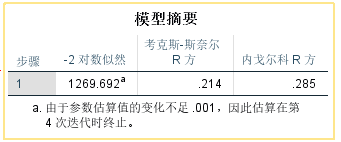
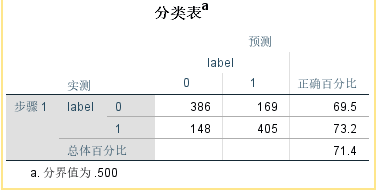
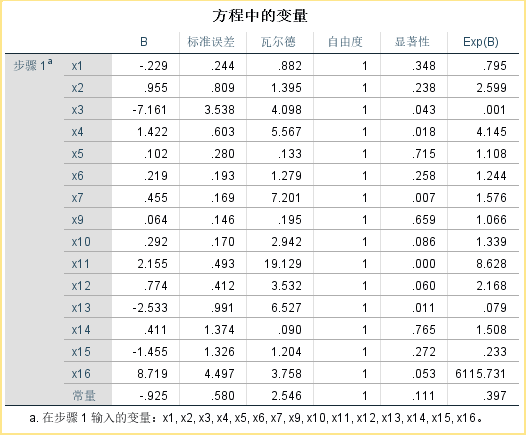

可以看到，二元逻辑回归的准确率在71.4，这对于预测一个选手在实际比赛中能否获得单词game已经非常不错
* 相对于问题1的结果，现有的结果有许多原本不显著的变量也开始显著
#### 额外的，因为二元逻辑回归的性能本身是有限的，我们希望能够选取更加优秀的模型进行预测，所以采用了一些经典的机器学习算法进行对比，使用accuracy、recall、precision、f1和auc进行评价，使用5折交叉验证法进行验证，结果如下:

In [6]:
import warnings
warnings.filterwarnings("ignore")

def function(model):
    auc = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='roc_auc').mean(),2)
    acc = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='accuracy').mean(),2)
    recall = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='recall').mean(),2)
    precision = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='precision').mean(),2)
    f1 = round(cross_val_score(model,dataset[columns].values,dataset['label'].values, cv=5,scoring='f1').mean(),2)
    return acc,recall,precision,f1,auc

model = LGBMClassifier(random_state=30,force_col_wise=True)
print(f'LGBMClassifier acc,recall,precision,f1,auc :{function(model)}')
model = XGBClassifier(random_state=50)
print(f'XGBClassifier acc,recall,precision,f1,auc :{function(model)}')
model = SVC(random_state=50)
print(f'SVC acc,recall,precision,f1,auc :{function(model)}')
model = MLPClassifier(random_state=60)
print(f'MLPClassifier acc,recall,precision,f1,auc :{function(model)}')
model = LogisticRegression(random_state=50)
print(f'LogisticRegression acc,recall,precision,f1,auc :{function(model)}')

  File "c:\Users\Transfer.DAVIDSG15\.conda\envs\mcm24\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Transfer.DAVIDSG15\.conda\envs\mcm24\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Transfer.DAVIDSG15\.conda\envs\mcm24\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Transfer.DAVIDSG15\.conda\envs\mcm24\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Number of positive: 442, number of negative: 444
[LightGBM] [Info] Total Bins 1430
[LightGBM] [Info] Number of data points in the train set: 886, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498871 -> initscore=-0.004515
[LightGBM] [Info] Start training from score -0.004515
[LightGBM] [Info] Number of positive: 442, number of negative: 444
[LightGBM] [Info] Total Bins 1427
[LightGBM] [Info] Number of data points in the train set: 886, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498871 -> initscore=-0.004515
[LightGBM] [Info] Start training from score -0.004515
[LightGBM] [Info] Number of positive: 442, number of negative: 444
[LightGBM] [Info] Total Bins 1424
[LightGBM] [Info] Number of data points in the train set: 886, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498871 -> initscore=-0.004515
[LightGBM] [Info] Start training from score -0.004515
[LightGBM] [Warning] N

[LightGBM] [Info] Number of positive: 441, number of negative: 445
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1432
[LightGBM] [Info] Number of data points in the train set: 886, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497743 -> initscore=-0.009029
[LightGBM] [Info] Start training from score -0.009029


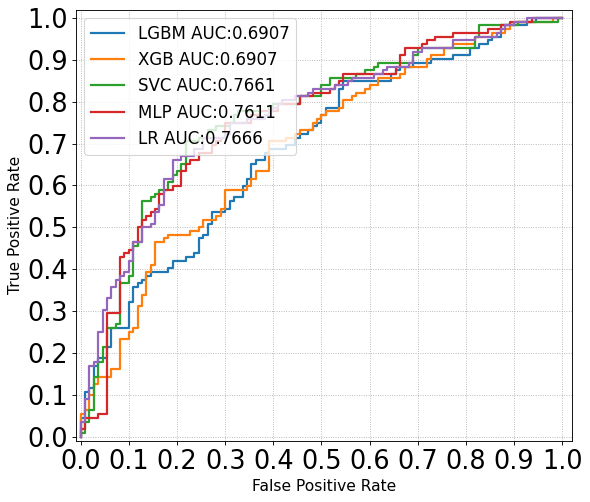

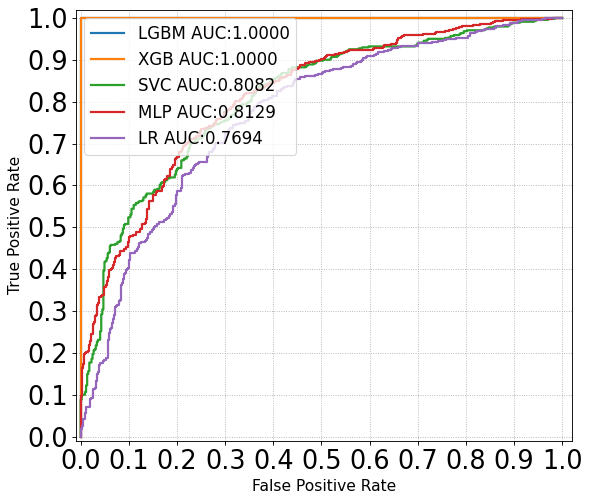

In [7]:
import numpy as np
from sklearn import metrics
def f(model_list,name_list,types='train'):
    plt.figure(figsize=(8, 7), dpi=80, facecolor='w')    # dpi:每英寸长度的像素点数；facecolor 背景颜色
    plt.xlim((-0.01, 1.02))  # x,y 轴刻度的范围
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))  #绘制刻度
    plt.yticks(np.arange(0, 1.1, 0.1))
    
    if types == 'test':
        for model,name in zip(model_list,name_list):
            ytest_prob = model.predict_proba(xvalid)[:,1]
            fpr, tpr, _ = metrics.roc_curve(yvalid, ytest_prob)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, '-', lw=2, label=f'{name} AUC:%.4f' % auc)  # 绘制AUC 曲线
    else:
        for model,name in zip(model_list,name_list):
            ytest_prob = model.predict_proba(xtrain)[:,1]
            fpr, tpr, _ = metrics.roc_curve(ytrain, ytest_prob)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, '-', lw=2, label=f'{name} AUC:%.4f' % auc)  # 绘制AUC 曲线
    plt.legend(loc='upper left',fontsize=15)    # 设置显示标签的位置
    plt.xlabel('False Positive Rate', fontsize=14)   #绘制x,y 坐标轴对应的标签
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.tick_params(labelsize=23)

    plt.grid(True, ls=':')  # 绘制网格作为底板;b是否显示网格线；ls表示line style
   #plt.savefig(f'roc_auc({types}(采样前)).png',dpi=500)
    plt.show()
    

xtrain, xvalid, ytrain, yvalid = train_test_split(dataset[columns].values,dataset['label'].values,random_state=620,test_size=0.2)

model1 = LGBMClassifier(random_state=30)
model2 = XGBClassifier(random_state=50)
model3 = SVC(probability=True,random_state=50)
model4 = MLPClassifier(random_state=60)
model5 = LogisticRegression(random_state=50)

model1.fit(xtrain,ytrain)
model2.fit(xtrain,ytrain)
model3.fit(xtrain,ytrain)
model4.fit(xtrain,ytrain)
model5.fit(xtrain,ytrain)

f([model1,model2,model3,model4,model5],['LGBM','XGB','SVC','MLP','LR'],'test')
f([model1,model2,model3,model4,model5],['LGBM','XGB','SVC','MLP','LR'],'train')


对于单次game的预测，我们可以发现传统的机器学习模型相对于树模型有更好的表现，其中，表现最好的应该是SVC，因为它的f1得分最高，意味着对所有样本的预测能够兼顾到每个类别的样本

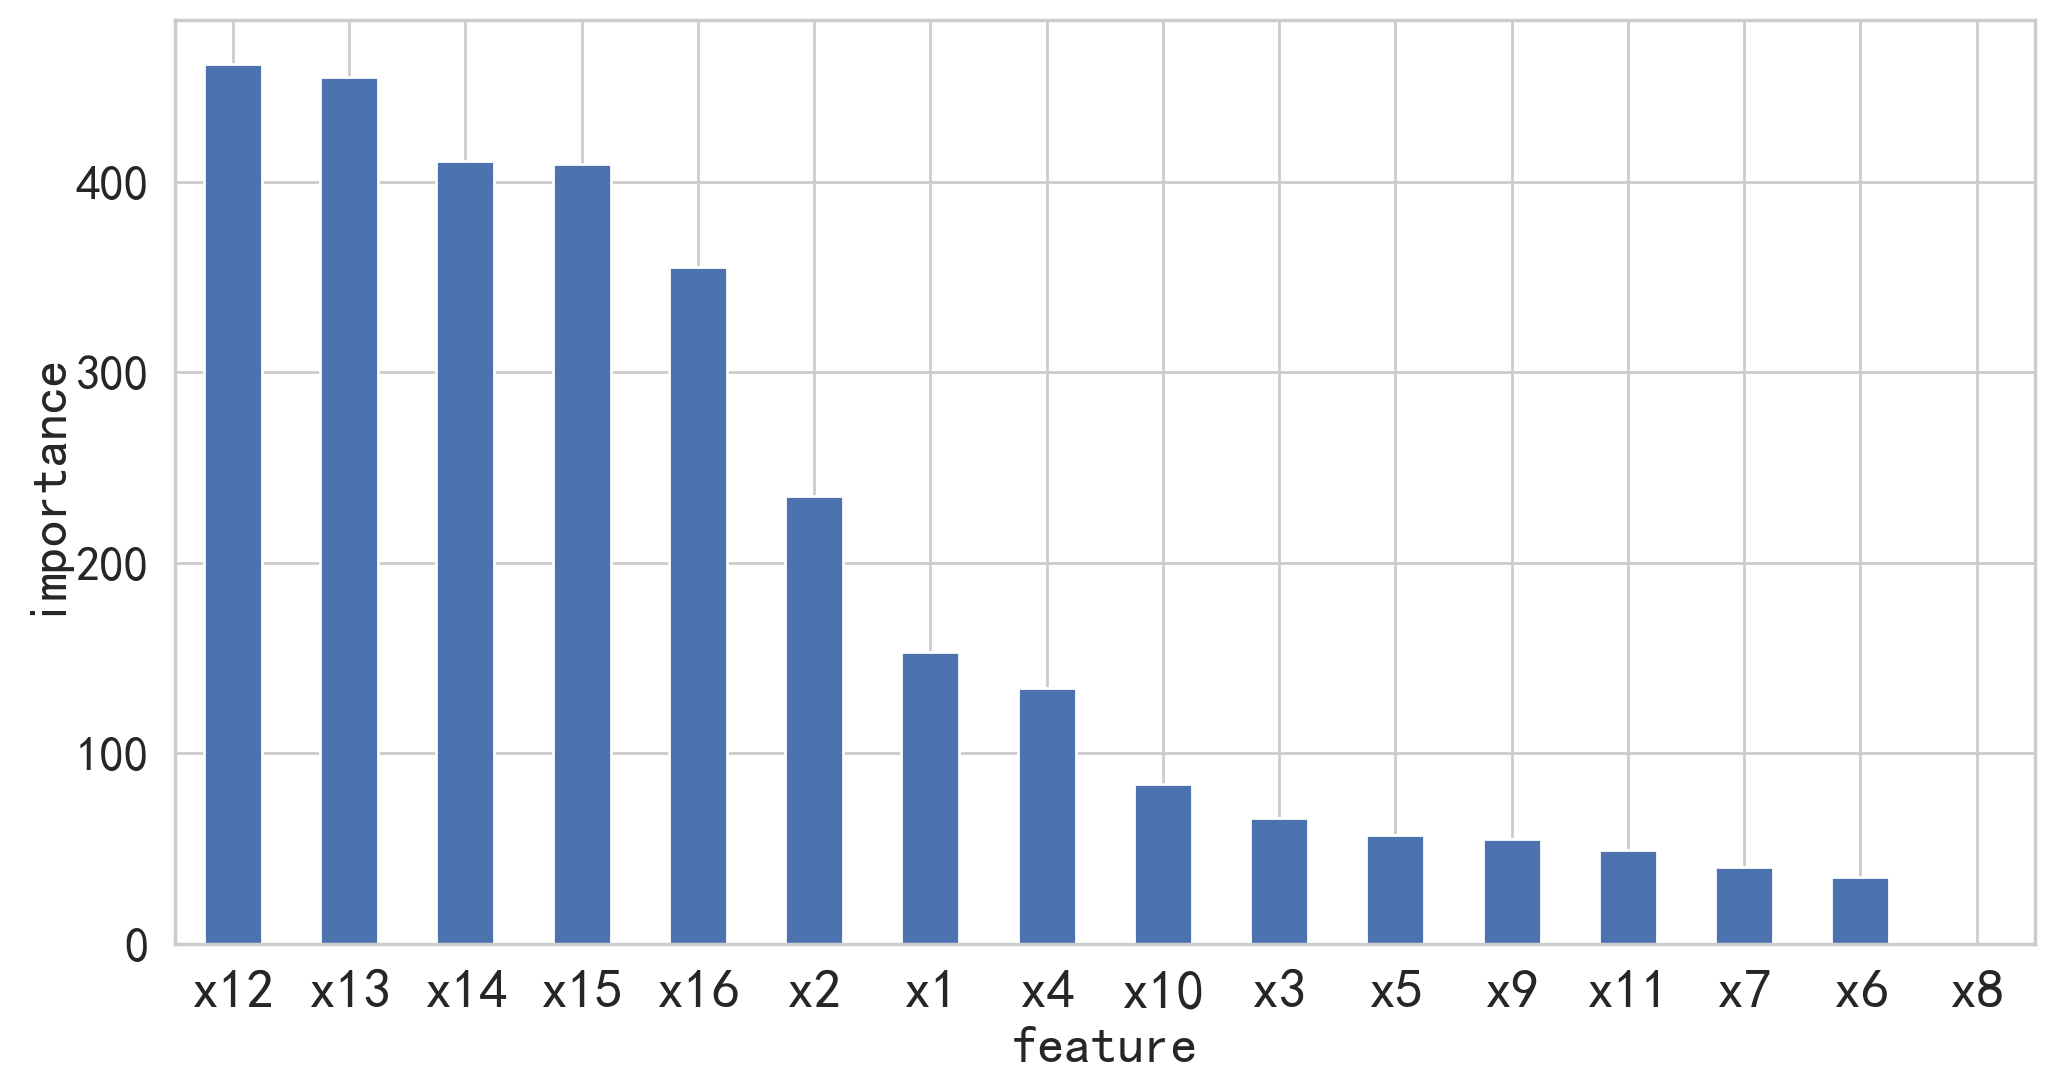

In [8]:
## 导入会使用到的库
%config InlineBackend.figure_format = 'retina'
%matplotlib inline    
import seaborn as sns 
sns.set(font= "simhei",style="whitegrid",font_scale=1.6)
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False # 解决坐标轴的负号显示问题
import matplotlib.pyplot as plt
import plotly.express as px

#输出重要性得分
f = pd.DataFrame({'col':list(columns),'score':model1.feature_importances_}).sort_values(by='score',ascending=False)
f.index = f['col']
f["score"].plot(kind = "bar",figsize = (12,6)) #颜色,matplotlib
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(rotation = 0,fontsize = 20)
#plt.savefig('特征重要性得分.png',dpi=500,bbox_inches='tight')
plt.show()

#### 在这一基础上，我们重新训练模型，同样使用表现最好的SVC模型，选取 2023 年温布尔登男单决赛中，20 岁的西班牙新星卡洛斯·阿尔卡拉兹击败了 36 岁的诺瓦 克·德约科维奇的经典对局进行实时的表现可视化，选取的选手为Carlos Alcaraz

In [9]:
t = dataset.copy()
t['game'] = [i[:19] for i in t.index]
index = t[t.game=='2023-wimbledon-1701'].reset_index(drop=True).index

test = dataset.reset_index(drop=True).iloc[index]
train = dataset.reset_index(drop=True).drop(index,axis=0)

In [10]:
model = SVC(random_state=50,probability=True)
model.fit(train[columns].values,train['label'].values)
pred = model.predict_proba(test[columns].values)
pred = pd.DataFrame({'实时得分':pred[:,1]},index=index)


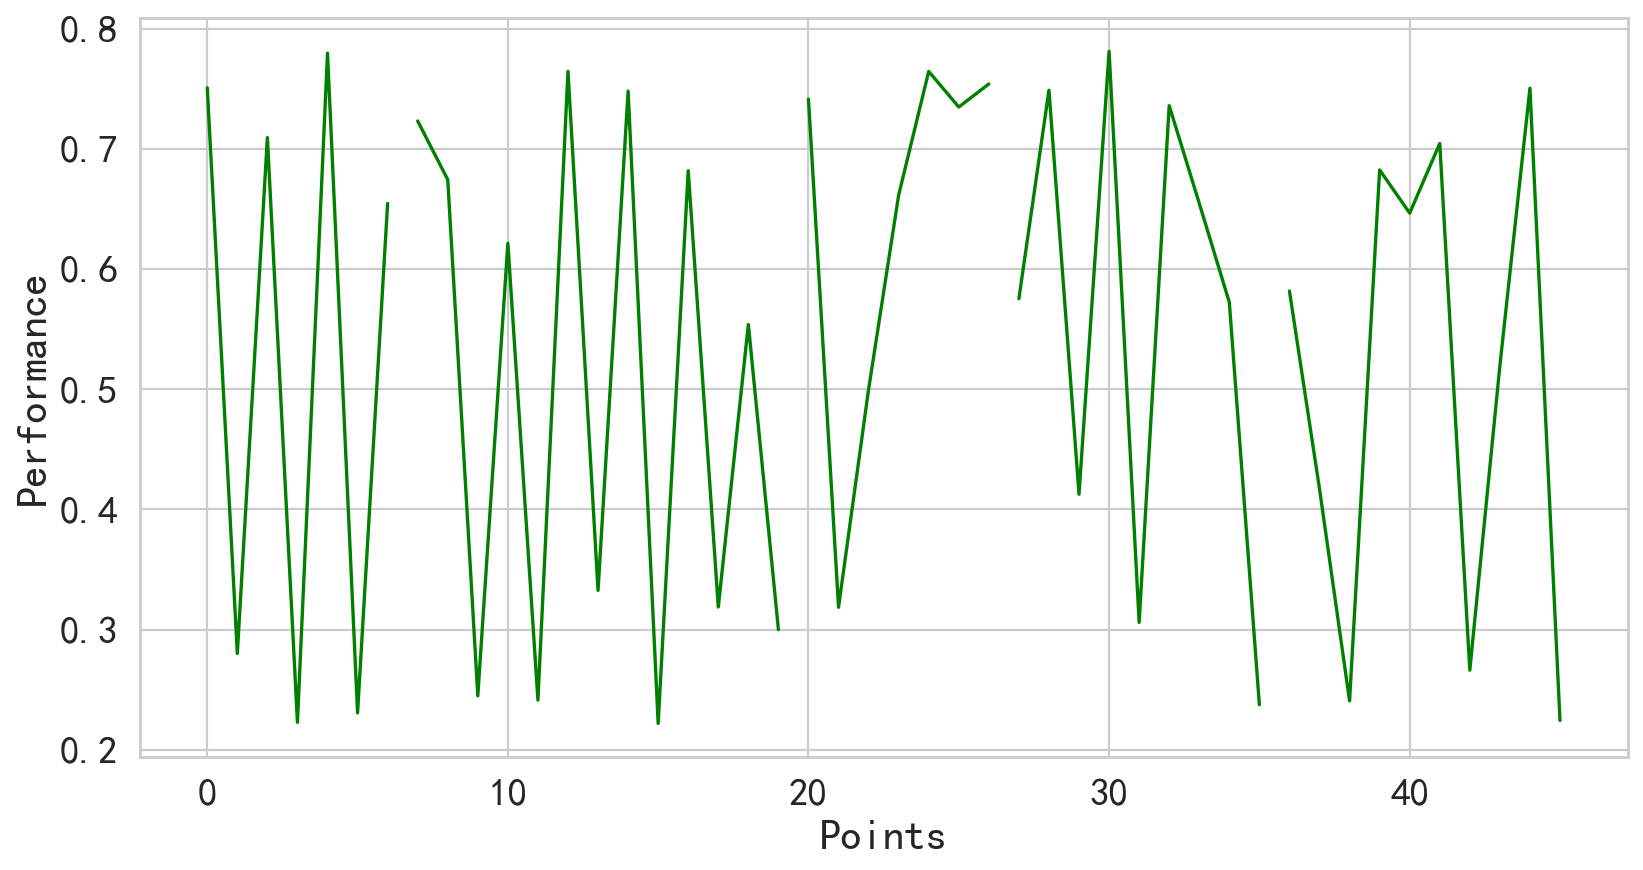

In [11]:
plt.figure(figsize=(12, 6), dpi=80, facecolor='w')

index = t[t.game=='2023-wimbledon-1701'].index

for o in range(5):
    condition = [str(i)[:21] == f'2023-wimbledon-1701-{o+1}' for i in index]
    plt.plot(pred[condition].index,pred[condition].values,color='green')


plt.xlabel("Points")
plt.ylabel("Performance")
#plt.savefig('经典对决实时走势.png',dpi=500)
plt.show()

### 由于支持向量机无法在高斯核的前提下计算特征重要性得分，我们采用了信息增益算法进行特征重要性得分计算


In [12]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np

# 创建特征数据集X和目标变量y
X = train[columns].values
y = train['label'].values
 
# 将特征数据转换为numpy数组
X = np.array(X)
 
# 计算每个特征的信息增益
ls = []
for i in range(X.shape[1]):
    gain = mutual_info_classif(X[:,i].reshape(-1,1), y)[0]
    ls.append(gain)
    
name = ['当前set中赢得的game数量', '本场game的得分领先进度', '是否为发球者', '上一个point是否得分', '本场match的set领先进度', '本场game是否发球得分（无触碰）', '本场game是否回击得分（无触碰）', '本场game是否出现双误', '本场game是否出现非强迫失误', '上网次数与上网得分比例', '本场set内对方发球时获得得分机会与实际获得得分的比例', '本场match内总计跑图里程', '最近三个point内的总计跑图里程', '上一个point跑图里程', '发球实时配速', '是否为发球者和发球实时配速交互项']
result = pd.DataFrame({'feature':columns,'name':name,'score':ls}).sort_values(by='score',ascending=False)
result.to_excel('信息增益计算结果.xlsx')
result

,feature,name,score
1,x2,本场game的得分领先进度,0.084170
3,x4,上一个point是否得分,0.070838
9,x10,上网次数与上网得分比例,0.040052
6,x7,本场game是否回击得分（无触碰）,0.033157
15,x16,是否为发球者和发球实时配速交互项,0.011610
8,x9,本场game是否出现非强迫失误,0.009867
10,x11,本场set内对方发球时获得得分机会与实际获得得分的比例,0.009219
0,x1,当前set中赢得的game数量,0.002929
7,x8,本场game是否出现双误,0.002875
5,x6,本场game是否发球得分（无触碰）,0.002678


#### 根据这一结果，可以知道game的得分领先进度最有利于提高选手的表现，然后是上一个point是否得分（均值），这意味着这个选手的手感火热，同时，排在第三的无触碰回击得分也能显示选手的手感